# Twitter US Airline Sentiment with Keras

## 1. Domain introduction
[Twitter US Airline Sentiment](https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment) is a popular NLP dataset on Kaggle. It contains Twitter reviews of the US airlines. Each one has a sentiment attached to it - positive, neutral or negative. 

In this article, I will present my approach to guessing the sentiment of a particular opinion.

## 2. Data description and visualization

First, let's check first few rows of the raw data: 

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("Tweets.csv")

df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


My goal is to determine sentiment based only on the Tweet itself, so I will remove additional columns, expand the columns width and show more rows:

In [2]:
pd.set_option("display.max_colwidth", 200)
simple_df = df.loc[:, ["text", "airline_sentiment"]]
simple_df.head(15)

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials to the experience... tacky.,positive
2,@VirginAmerica I didn't today... Must mean I need to take another trip!,neutral
3,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",negative
4,@VirginAmerica and it's a really big bad thing about it,negative
5,@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.\nit's really the only bad thing about flying VA,negative
6,"@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)",positive
7,"@VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. https://t.co/mWpG7grEZP",neutral
8,"@virginamerica Well, I didn't…but NOW I DO! :-D",positive
9,"@VirginAmerica it was amazing, and arrived an hour early. You're too good to me.",positive


Few informations about opinions length and sentiment:

Mean single Twitt's lengh: 103.82 characters


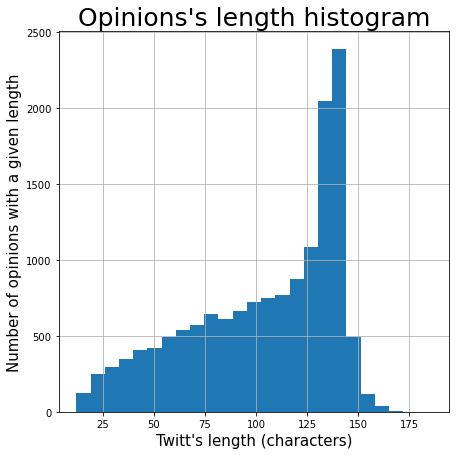

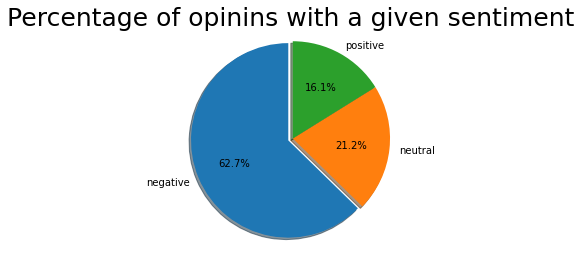

In [3]:
import matplotlib.pyplot as plt

print("Mean single Twitt's lengh: %.2f characters" % df["text"].str.len().mean())
df["text"].str.len().hist(figsize=(7, 7), bins=25)
plt.xlabel("Twitt's length (characters)", fontsize=15)
plt.ylabel("Number of opinions with a given length", fontsize=15)
plt.title("Opinions's length histogram", fontsize=25)
plt.show()

labels = ['negative', 'neutral', 'positive']
negative = df[df.airline_sentiment == 'negative'].size
neutral = df[df.airline_sentiment == 'neutral'].size
positive = df[df.airline_sentiment == 'positive'].size
explode = [0.05, 0.0, 0.0]
sizes = [negative, neutral, positive]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, explode=explode, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Percentage of opinins with a given sentiment", fontsize=25)
plt.show()

## 3. Baseline model

I usually start with a fairly simple model to know how my actions affect the outcome.

### 3.1 Label encoding
First we have to encode the labels into a form that the algorithm understands - numbers:

In [4]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(simple_df["airline_sentiment"])
simple_df.loc[:,"sentiment_encoded"] = le.transform(simple_df["airline_sentiment"])

labels = simple_df["airline_sentiment"].unique()
labels_encoded = le.transform(labels)

for idx in range(len(labels)):
    print("Number for " + labels[idx] + " sentiment: " + str(labels_encoded[idx]))

simple_df.head()

Number for neutral sentiment: 1
Number for positive sentiment: 2
Number for negative sentiment: 0


,text,airline_sentiment,sentiment_encoded
0,@VirginAmerica What @dhepburn said.,neutral,1
1,@VirginAmerica plus you've added commercials to the experience... tacky.,positive,2
2,@VirginAmerica I didn't today... Must mean I need to take another trip!,neutral,1
3,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",negative,0
4,@VirginAmerica and it's a really big bad thing about it,negative,0


### 3.2 Split train and test data
Second - I will choose some special test data to check model performance. Pay attention to the "stratify" parameter - it ensures that all the sentiment types will be in the same proportion.

In [5]:
from sklearn.model_selection import train_test_split
from keras.utils import np_utils


X_train, X_test, y_train, y_test = train_test_split(
     simple_df['text'], simple_df['sentiment_encoded'], test_size=0.2, random_state=42, stratify=simple_df['sentiment_encoded'])

y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

### 3.3 Changing the collection type, splitting into batches

TensorFlow has an internal type for datasets - tf.data.Dataset. Just as [documentation](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) mentions - "Iteration happens in a streaming fashion, so the full dataset does not need to fit into memory.". Next - I'll combine consecutive consecutive elements into batches of the size I'll specify. TensorFlow will feed neural network in this number of rows at a time. This topic is a bit complicated for this article - you can find more information [here ("What is a batch?")](https://stackoverflow.com/a/41176694) and [here (tips for batch size)](https://stats.stackexchange.com/questions/164876/what-is-the-trade-off-between-batch-size-and-number-of-iterations-to-train-a-neu/236393#236393).

In [6]:
import tensorflow as tf

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

BATCH_SIZE = 32

train_ds = train_ds.batch(BATCH_SIZE)
test_ds = test_ds.batch(BATCH_SIZE)

print(f"Number of batches in train_ds: {train_ds.cardinality()}")
print(f"Number of batches in test_ds: {test_ds.cardinality()}")

Number of batches in train_ds: 366
Number of batches in test_ds: 92


2022-10-09 14:20:55.937565: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-09 14:20:56.143772: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-09 14:20:56.143929: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-09 14:20:56.161460: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

### 3.4 Encoding Twitts

In one of the previous parts I changed labels to a version that the algorithm understands. Now we need to do something similar with Twitts. There are some more sophisticated tools, but for now I will choose the standard one - TextVectorizer. I encourage you to check out more informations about this processing: [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization).

In [7]:
from tensorflow.keras.layers import TextVectorization
import string
import re

max_features = 20000
embedding_dim = 128
sequence_length = 500

vectorize_layer = TextVectorization(
    max_tokens=max_features,
    output_mode="int",
    output_sequence_length=sequence_length,
)

text_ds = train_ds.map(lambda x, y: x)

#Train Vectorizer
vectorize_layer.adapt(text_ds)

def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

# Vectorize the data.
train_ds = train_ds.map(vectorize_text)
test_ds = test_ds.map(vectorize_text)

# Do async prefetching / buffering of the data for best performance on GPU.
#TODO: more information about .prefetch
train_ds = train_ds.cache().prefetch(buffer_size=10)
test_ds = test_ds.cache().prefetch(buffer_size=10)

2022-10-09 14:20:59.074080: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


### 3.5 Defining the network

TODO: add more informations

In [10]:
from tensorflow.keras import layers
import keras

# A integer input for vocab indices.
inputs = tf.keras.Input(shape=(None,), dtype="int64")

# Next, we add a layer to map those vocab indices into a space of dimensionality
# 'embedding_dim'.
x = layers.Embedding(max_features, embedding_dim)(inputs)
x = layers.Dropout(0.5)(x)

# Conv1D + global max pooling
x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Flatten()(x)

# We add a vanilla hidden layer:
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)

# We project onto a single unit output layer, and squash it with a sigmoid:
predictions = layers.Dense(3, activation="softmax", name="predictions")(x)

model = tf.keras.Model(inputs, predictions)

# Compile the model with binary crossentropy loss and an adam optimizer.
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=[keras.metrics.AUC(name='auc'), "accuracy"])

epochs = 50

model.fit(train_ds, validation_data=test_ds, epochs=epochs)

Epoch 1/50


2022-10-09 14:26:05.537781: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


366/366 [==============================] - 7s 4ms/step - loss: 0.7202 - auc: 0.8597 - accuracy: 0.6885 - val_loss: 0.5932 - val_auc: 0.9063 - val_accuracy: 0.7531
Epoch 2/50
366/366 [==============================] - 1s 4ms/step - loss: 0.4815 - auc: 0.9393 - accuracy: 0.8129 - val_loss: 0.5565 - val_auc: 0.9206 - val_accuracy: 0.7883
Epoch 3/50
366/366 [==============================] - 1s 4ms/step - loss: 0.3097 - auc: 0.9738 - accuracy: 0.8849 - val_loss: 0.5978 - val_auc: 0.9226 - val_accuracy: 0.7869
Epoch 4/50
366/366 [==============================] - 1s 4ms/step - loss: 0.1852 - auc: 0.9898 - accuracy: 0.9355 - val_loss: 0.7671 - val_auc: 0.9112 - val_accuracy: 0.7732
Epoch 5/50
366/366 [==============================] - 1s 4ms/step - loss: 0.1156 - auc: 0.9957 - accuracy: 0.9612 - val_loss: 0.8383 - val_auc: 0.9079 - val_accuracy: 0.7763
Epoch 6/50
366/366 [==============================] - 1s 4ms/step - loss: 0.0914 - auc: 0.9970 - accuracy: 0.9698 - val_loss: 0.9290 - val_au

Epoch 48/50
366/366 [==============================] - 1s 4ms/step - loss: 0.0194 - auc: 0.9996 - accuracy: 0.9941 - val_loss: 2.2015 - val_auc: 0.8748 - val_accuracy: 0.7626
Epoch 49/50
366/366 [==============================] - 1s 4ms/step - loss: 0.0141 - auc: 0.9998 - accuracy: 0.9956 - val_loss: 2.4509 - val_auc: 0.8722 - val_accuracy: 0.7616
Epoch 50/50
366/366 [==============================] - 1s 4ms/step - loss: 0.0194 - auc: 0.9995 - accuracy: 0.9937 - val_loss: 2.0324 - val_auc: 0.8788 - val_accuracy: 0.7626


The result is better than random values or setting all predictions as "negative", but it's possible to obtain model with higher performance.